# 2D Solver Comparison

Run two 2D wave solvers, measure their runtime, and compare their field outputs on the same grid.

## How to use

1. Edit `shared_parfile_params` in the configuration cell so it contains the full parameter set you want both solvers to run.
2. Make sure every value is compatible with each solver (for example include `frac_bits` if the fixed-point solver needs it).
3. Run the notebook cells in order to execute the solvers, view the runtime summaries, and inspect the error metrics and plots.

All solver outputs are written to solver-specific temporary folders under your system's temp directory so notebook cells can reuse them.

In [5]:
from __future__ import annotations

import os
import math
import re
import subprocess
import sys
import tempfile
import time
import warnings
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, List, Optional, Sequence, Tuple

import h5py
import numpy as np

try:
    import pandas as pd
except ModuleNotFoundError:
    pd = None

import matplotlib.pyplot as plt

plt.rcParams.update({"figure.figsize": (7.5, 6), "image.cmap": "coolwarm"})

In [16]:

project_root = Path.cwd()

# Configure the complete parfile to use for every solver run.
shared_parfile_params = {
    "Nt": 10000,
    "Nx": 1601,
    "Ny": 1601,
    "Xmin": -5.0,
    "Xmax": 5.0,
    "Ymin": -5.0,
    "Ymax": 5.0,
    "output_interval": 50,
    "cfl": 0.1,
    "bound_cond": "REFLECT",
    "ko_sigma": 0.05,
    "id_x0": 1.0,
    "id_y0": 1.0,
    "id_sigma": 1.0,
    "id_amp": 1.0,
    "frac_bits": 20,
}

solvers_to_compare = [
    {
        "name": "FP64",
        "solver": (project_root / "Solvers/2D_Wave/FP_64_Jax/JaxSolver.py").as_posix(),
    },
    {
        "name": "FixedPoint",
        "solver": (project_root / "Solvers/2D_Wave/Fixed_Point_Jax/JaxSolver.py").as_posix(),
    },
]

_JAX_GPU_BACKEND: Optional[str] = None


def _is_jax_solver(spec: Dict[str, object]) -> bool:
    solver_path = Path(spec["solver"])
    lowered = [part.lower() for part in solver_path.parts]
    lowered.append(solver_path.name.lower())
    return any("jax" in part for part in lowered)


def _infer_backend_from_device(dev) -> Optional[str]:
    version = getattr(dev, "platform_version", None)
    if isinstance(version, str) and version:
        token = version.split()[0].lower()
        if token in {"cuda", "rocm"}:
            return token
    kind = getattr(dev, "device_kind", None)
    if isinstance(kind, str):
        lowered = kind.lower()
        if "cuda" in lowered:
            return "cuda"
        if "rocm" in lowered or "amd" in lowered:
            return "rocm"
    client = getattr(dev, "client", None)
    platform = getattr(client, "platform", None)
    if isinstance(platform, str) and platform.lower() in {"cuda", "rocm"}:
        return platform.lower()
    platform_attr = getattr(dev, "platform", None)
    if isinstance(platform_attr, str) and platform_attr.lower() in {"cuda", "rocm"}:
        return platform_attr.lower()
    return None


def _ensure_jax_gpu_ready(solvers: Sequence[Dict[str, object]]) -> Optional[str]:
    global _JAX_GPU_BACKEND
    jax_specs = [spec for spec in solvers if _is_jax_solver(spec)]
    if not jax_specs:
        return None
    backend_override = os.environ.get("JAX_PLATFORMS")
    if backend_override:
        backend_lower = backend_override.lower()
        if backend_lower not in {"cuda", "rocm", "gpu"}:
            raise RuntimeError(
                "JAX_PLATFORMS environment variable is set to an unsupported platform: "
                + backend_override
            )
        _JAX_GPU_BACKEND = backend_lower
        print(
            "JAX GPU check skipped: using pre-set JAX_PLATFORMS="
            f"{os.environ['JAX_PLATFORMS']}."
        )
        return _JAX_GPU_BACKEND
    if _JAX_GPU_BACKEND:
        return _JAX_GPU_BACKEND
    try:
        import jax  # type: ignore[import]
    except ImportError as exc:  # pragma: no cover - informative failure path
        names = ", ".join(str(spec.get("name") or Path(spec["solver"]).stem) for spec in jax_specs)
        raise RuntimeError(
            f"JAX-backed solvers ({names}) require the 'jax' package with GPU support."
        ) from exc
    devices = jax.devices()
    gpu_devices = [dev for dev in devices if getattr(dev, "platform", "") == "gpu"]
    if not gpu_devices:
        platforms = {getattr(dev, "platform", "unknown") for dev in devices} or {"none"}
        raise RuntimeError(
            "Selected solvers require a GPU, but JAX reports available platforms: "
            + ", ".join(sorted(platforms))
        )

    backend_hint: Optional[str] = None
    for dev in gpu_devices:
        backend_hint = _infer_backend_from_device(dev)
        if backend_hint:
            break

    backend_hint = backend_hint or "gpu"
    _JAX_GPU_BACKEND = backend_hint
    device_summaries = ", ".join(f"{dev.device_kind} (id={dev.id})" for dev in gpu_devices)
    print(
        "JAX GPU check passed: "
        f"{len(gpu_devices)} GPU device(s) detected -> {device_summaries} | backend={_JAX_GPU_BACKEND}"
    )
    return _JAX_GPU_BACKEND


for spec in solvers_to_compare:
    solver_path = Path(spec["solver"])
    if not solver_path.exists():
        raise FileNotFoundError(f"Missing solver file: {solver_path}")

_ensure_jax_gpu_ready(solvers_to_compare)


JAX GPU check passed: 1 GPU device(s) detected -> NVIDIA GeForce GTX 1650 (id=0) | backend=gpu


'gpu'

In [20]:
@dataclass
class SolverRunResult:
    name: str
    solver_path: Path
    runtime: float
    params: Dict[str, object]
    dt: float
    steps: np.ndarray
    times: np.ndarray
    output_dir: Path
    temp_dir: Path
    file_map: Dict[int, Path]
    variables: Tuple[str, ...]
    grid: Dict[str, np.ndarray]
    stdout: str
    stderr: str


def _format_toml_value(value: object) -> str:
    if isinstance(value, str):
        return f'"{value}"'
    if isinstance(value, bool):
        return "true" if value else "false"
    if isinstance(value, (int, float)):
        return repr(value)
    raise TypeError(f"Unsupported parameter type {type(value)!r} for value {value!r}")


def _dump_params(path: Path, params: Dict[str, object]) -> None:
    lines = [f"{key} = {_format_toml_value(value)}" for key, value in params.items()]
    path.write_text("\n".join(lines) + "\n", encoding="utf-8")


def _compute_dt(params: Dict[str, object]) -> float:
    nx = int(params["Nx"])
    ny = int(params["Ny"])
    if nx < 2 or ny < 2:
        raise ValueError("Nx and Ny must be at least 2.")
    x_span = float(params["Xmax"]) - float(params["Xmin"])
    dx = x_span / (nx - 1)
    return float(params.get("cfl", 0.1)) * dx


_STEP_PATTERN = re.compile(r"wave_(\d+)\.h5$")


def _collect_outputs(output_dir: Path) -> Dict[int, Path]:
    files = sorted(output_dir.glob("wave_*.h5"))
    if not files:
        raise FileNotFoundError(f"No HDF5 outputs found in {output_dir}")
    step_map: Dict[int, Path] = {}
    for file_path in files:
        match = _STEP_PATTERN.match(file_path.name)
        if not match:
            continue
        step = int(match.group(1))
        step_map[step] = file_path
    if not step_map:
        raise ValueError(f"No step-indexed outputs matched in {output_dir}")
    return dict(sorted(step_map.items()))


def _read_grid_and_variables(file_path: Path) -> Tuple[Dict[str, np.ndarray], Tuple[str, ...]]:
    with h5py.File(file_path, "r") as h5:
        grid = {axis: h5[axis][()] for axis in ("X", "Y", "Z") if axis in h5}
        variables = tuple(sorted(key for key in h5.keys() if key not in {"X", "Y", "Z"}))
    return grid, variables


def _load_fields(file_path: Path, variables: Sequence[str]) -> Dict[str, np.ndarray]:
    with h5py.File(file_path, "r") as h5:
        return {var: h5[var][()] for var in variables}


def execute_solver(spec: Dict[str, object], base_params: Dict[str, object]) -> SolverRunResult:
    solver_path = Path(spec["solver"]).resolve()
    name = str(spec.get("name") or solver_path.stem)
    extra_params = dict(spec.get("extra_params") or {})

    merged_params = dict(base_params)
    for key, value in extra_params.items():
        if key in merged_params and merged_params[key] != value:
            raise ValueError("extra_params cannot override values from shared_parfile_params; edit the shared config instead.")
        merged_params[key] = value

    temp_dir = Path(tempfile.mkdtemp(prefix=f"{name.lower()}_run_"))
    output_dir = temp_dir / "output"
    merged_params["output_dir"] = output_dir.as_posix()
    tmp_parfile = temp_dir / "params.toml"
    output_dir.mkdir(parents=True, exist_ok=True)
    _dump_params(tmp_parfile, merged_params)

    env = None
    if _is_jax_solver(spec):
        env = dict(os.environ)
        platform_override = spec.get("jax_platform")
        if platform_override is not None:
            requested = str(platform_override).lower()
            if requested not in {"cpu", "gpu", "cuda", "rocm"}:
                raise ValueError(
                    "jax_platform must be one of {'cpu', 'gpu', 'cuda', 'rocm'}, "
                    f"got {platform_override!r}."
                )
            if requested == "cpu":
                env["JAX_PLATFORMS"] = "cpu"
                env["JAX_PLATFORM_NAME"] = "cpu"
            else:
                backend_choice = requested
                if backend_choice == "gpu":
                    backend_choice = _ensure_jax_gpu_ready([spec]) or "gpu"
                else:
                    _ensure_jax_gpu_ready([spec])
                env_backend = "cuda" if backend_choice == "gpu" else backend_choice
                env["JAX_PLATFORMS"] = env_backend
                env["JAX_PLATFORM_NAME"] = "gpu"
        else:
            backend_choice = _ensure_jax_gpu_ready([spec]) or "gpu"
            env_backend = "cuda" if backend_choice == "gpu" else backend_choice
            env["JAX_PLATFORMS"] = env_backend
            env["JAX_PLATFORM_NAME"] = "gpu"

    cmd = [sys.executable, str(solver_path), str(tmp_parfile), str(output_dir)]
    start = time.perf_counter()
    proc = subprocess.run(
        cmd,
        cwd=solver_path.parent,
        text=True,
        capture_output=True,
        check=False,
        env=env,
    )
    runtime = time.perf_counter() - start
    if proc.returncode != 0:
        raise RuntimeError(
            f"Solver {name} failed with exit code {proc.returncode}\nSTDOUT:\n{proc.stdout}\nSTDERR:\n{proc.stderr}"
        )

    step_map = _collect_outputs(output_dir)
    first_output = next(iter(step_map.values()))
    grid, variables = _read_grid_and_variables(first_output)
    dt = _compute_dt(merged_params)
    steps = np.array(list(step_map.keys()))
    times = steps * dt

    return SolverRunResult(
        name=name,
        solver_path=solver_path,
        runtime=runtime,
        params=dict(merged_params),
        dt=dt,
        steps=steps,
        times=times,
        output_dir=output_dir,
        temp_dir=temp_dir,
        file_map=step_map,
        variables=variables,
        grid=grid,
        stdout=proc.stdout,
        stderr=proc.stderr,
    )


def compare_solver_runs(
    run_a: SolverRunResult,
    run_b: SolverRunResult,
    variables: Optional[Sequence[str]] = None,
) -> Dict[str, object]:
    vars_a = set(run_a.variables)
    vars_b = set(run_b.variables)
    if variables is None:
        shared_vars = tuple(sorted(vars_a & vars_b))
    else:
        shared_vars = tuple(sorted(var for var in variables if var in vars_a and var in vars_b))
    if not shared_vars:
        raise ValueError("No common variables found between solvers.")
    if not math.isclose(run_a.dt, run_b.dt, rel_tol=1e-9, abs_tol=1e-12):
        raise ValueError("Time step mismatch; adjust shared_parfile_params so dt matches.")
    for axis in ("X", "Y"):
        ga = run_a.grid.get(axis)
        gb = run_b.grid.get(axis)
        if ga is not None and gb is not None:
            if ga.shape != gb.shape:
                raise ValueError(f"Grid size mismatch detected for axis {axis}.")
            if not np.allclose(ga, gb, rtol=5e-4, atol=1e-5):
                max_diff = float(np.max(np.abs(ga - gb)))
                warnings.warn(
                    f"Minor grid mismatch detected for axis {axis} (max |diff|={max_diff:.3e}). Continuing with reference grid from first solver.",
                    RuntimeWarning,
                )

    shared_steps = sorted(set(run_a.file_map) & set(run_b.file_map))
    if not shared_steps:
        raise ValueError("No common output steps between solvers.")

    per_step: List[Dict[str, float]] = []
    for step in shared_steps:
        data_a = _load_fields(run_a.file_map[step], shared_vars)
        data_b = _load_fields(run_b.file_map[step], shared_vars)
        row: Dict[str, float] = {"step": float(step), "time": float(step * run_a.dt)}
        for var in shared_vars:
            diff = data_a[var] - data_b[var]
            l2 = float(np.sqrt(np.mean(diff ** 2)))
            linf = float(np.max(np.abs(diff)))
            row[f"{var}_l2"] = l2
            row[f"{var}_linf"] = linf
        row["combined_l2"] = float(math.sqrt(sum(row[f"{var}_l2"] ** 2 for var in shared_vars)))
        row["combined_linf"] = float(max(row[f"{var}_linf"] for var in shared_vars))
        per_step.append(row)

    times = np.array([step * run_a.dt for step in shared_steps])
    final = per_step[-1]
    return {
        "variables": shared_vars,
        "steps": shared_steps,
        "times": times,
        "per_step": per_step,
        "final": final,
    }


def plot_field_difference(
    run_a: SolverRunResult,
    run_b: SolverRunResult,
    step: int,
    variable: str,
) -> Tuple[plt.Figure, plt.Axes]:
    if step not in run_a.file_map or step not in run_b.file_map:
        raise KeyError(f"Step {step} not found in both runs.")
    data_a = _load_fields(run_a.file_map[step], (variable,))
    data_b = _load_fields(run_b.file_map[step], (variable,))
    diff = data_a[variable] - data_b[variable]
    x = run_a.grid.get("X")
    y = run_a.grid.get("Y")
    extent = None
    if x is not None and y is not None:
        extent = [float(np.min(x)), float(np.max(x)), float(np.min(y)), float(np.max(y))]
    fig, ax = plt.subplots()
    im = ax.imshow(diff, origin="lower", extent=extent, aspect="auto")
    ax.set_title(f"{variable} difference at step {step}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    fig.colorbar(im, ax=ax, shrink=0.8, label="difference")
    return fig, ax

In [17]:
runs: List[SolverRunResult] = []
for spec in solvers_to_compare:
    print(f"Running {spec['name']} ({spec['solver']})...")
    result = execute_solver(spec, shared_parfile_params)
    runs.append(result)
    print(
        f"  Runtime: {result.runtime:.2f} s | dt={result.dt:.3e} | outputs={len(result.file_map)} | dir={result.output_dir}"
    )

if pd is not None and runs:
    runtime_df = pd.DataFrame(
        {
            "solver": [run.name for run in runs],
            "runtime_s": [run.runtime for run in runs],
            "dt": [run.dt for run in runs],
            "outputs": [len(run.file_map) for run in runs],
            "output_dir": [str(run.output_dir) for run in runs],
        }
    )
    display(runtime_df)
elif runs:
    for run in runs:
        print(
            f"{run.name}: runtime={run.runtime:.2f}s, dt={run.dt:.3e}, outputs={len(run.file_map)}, dir={run.output_dir}"
        )

Running FP64 (/mnt/c/Users/bryso/Documents/GitHub/Rationals/Solvers/2D_Wave/FP_64_Jax/JaxSolver.py)...
  Runtime: 461.72 s | dt=6.250e-04 | outputs=201 | dir=/tmp/fp64_run_c7rt_8f7/output
Running FixedPoint (/mnt/c/Users/bryso/Documents/GitHub/Rationals/Solvers/2D_Wave/Fixed_Point_Jax/JaxSolver.py)...
  Runtime: 497.28 s | dt=6.250e-04 | outputs=201 | dir=/tmp/fixedpoint_run_hypgn7oc/output


,solver,runtime_s,dt,outputs,output_dir
0,FP64,461.718646,0.000625,201,/tmp/fp64_run_c7rt_8f7/output
1,FixedPoint,497.280930,0.000625,201,/tmp/fixedpoint_run_hypgn7oc/output


In [21]:
comparison_result = None
if len(runs) >= 2:
    run_a, run_b = runs[0], runs[1]
    comparison_result = compare_solver_runs(run_a, run_b)
    if pd is not None:
        comparison_df = pd.DataFrame(comparison_result["per_step"])
        display(comparison_df)
    else:
        for row in comparison_result["per_step"]:
            print(row)
    final = comparison_result["final"]
    print(
        f"Final combined L2={final['combined_l2']:.3e}, combined Linf={final['combined_linf']:.3e}"
    )
else:
    print("Add at least two solvers to compare.")


/tmp/ipykernel_7401/3257058269.py:186: RuntimeWarning: Minor grid mismatch detected for axis X (max |diff|=6.104e-04). Continuing with reference grid from first solver.
  warnings.warn(
/tmp/ipykernel_7401/3257058269.py:186: RuntimeWarning: Minor grid mismatch detected for axis Y (max |diff|=6.104e-04). Continuing with reference grid from first solver.
  warnings.warn(


,step,time,chi_l2,chi_linf,phi_l2,phi_linf,combined_l2,combined_linf
0,0.0,0.00000,0.000000,0.000000,0.000067,0.000352,0.000067,0.000352
1,50.0,0.03125,0.008086,6.405466,0.000078,0.011402,0.008086,6.405466
2,100.0,0.06250,0.010063,10.967308,0.000082,0.008606,0.010064,10.967308
3,150.0,0.09375,0.011026,12.783341,0.000086,0.007595,0.011026,12.783341
4,200.0,0.12500,0.010748,12.420427,0.000089,0.013646,0.010749,12.420427
...,...,...,...,...,...,...,...,...
196,9800.0,6.12500,0.066154,1.256644,0.001587,0.015173,0.066173,1.256644
197,9850.0,6.15625,0.066421,1.253742,0.001595,0.015435,0.066440,1.253742
198,9900.0,6.18750,0.066682,1.286300,0.001603,0.015449,0.066701,1.286300
199,9950.0,6.21875,0.066948,1.262374,0.001611,0.015550,0.066967,1.262374


Final combined L2=6.723e-02, combined Linf=1.306e+00


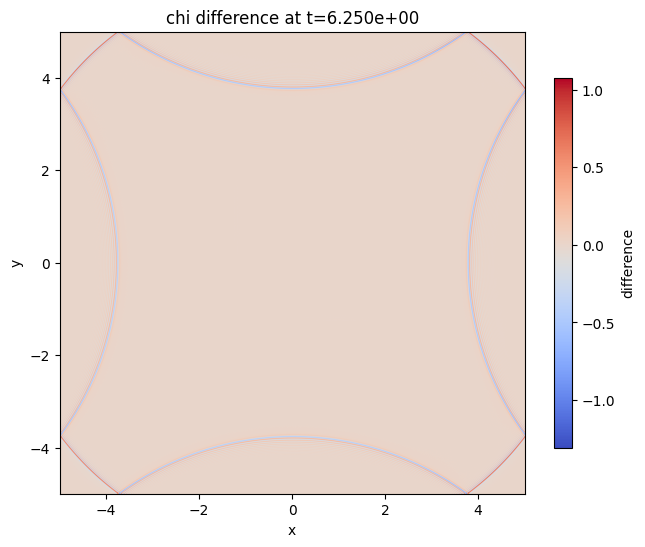

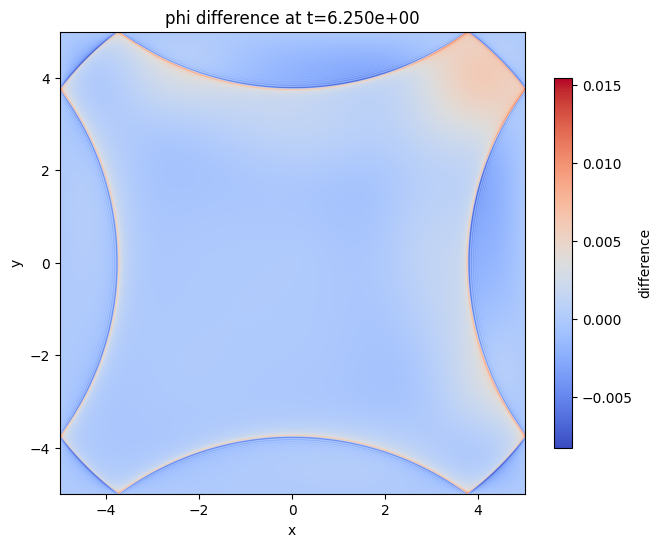

In [22]:
if comparison_result is None:
    raise RuntimeError("Run the comparison cell above to produce metrics before plotting.")

last_step = int(comparison_result["steps"][-1])
last_time = float(comparison_result["times"][-1])
for var in comparison_result["variables"]:
    fig, ax = plot_field_difference(runs[0], runs[1], last_step, var)
    ax.set_title(f"{var} difference at t={last_time:.3e}")
    plt.show()


## JAX CPU vs GPU performance

Compare the `Fixed_Point_Jax` solver runtime on CPU versus GPU while doubling the mesh resolution.

In [ ]:

# Compare the Fixed_Point_Jax solver on CPU vs GPU across increasing mesh resolutions.
jax_solver_path = project_root / "Solvers/2D_Wave/Fixed_Point_Jax/JaxSolver.py"
if not jax_solver_path.exists():
    raise FileNotFoundError(f"Missing JAX solver at {jax_solver_path}")

# Keep the total simulated time consistent so each refinement integrates over the same interval.
base_final_time = shared_parfile_params["Nt"] * _compute_dt(shared_parfile_params)

# Preserve roughly the same number of outputs as the shared configuration when Nt changes.
target_output_count = 0
if shared_parfile_params.get("output_interval", 0):
    target_output_count = max(
        1,
        shared_parfile_params["Nt"] // shared_parfile_params["output_interval"],
    )

base_nx = max(32, int(shared_parfile_params["Nx"] // 2))
mesh_sizes = [base_nx * (2 ** idx) for idx in range(5)]
platform_settings = [
    ("CPU", "cpu", "o"),
    ("GPU", "gpu", "s"),
]

performance_records: List[Dict[str, object]] = []
for platform_label, platform_key, marker in platform_settings:
    if platform_key != "cpu":
        _ensure_jax_gpu_ready(
            [{"name": f"FixedPointJax-{platform_label}", "solver": jax_solver_path}]
        )
    for nx in mesh_sizes:
        run_params = dict(shared_parfile_params)
        run_params["Nx"] = nx
        run_params["Ny"] = nx
        dt = _compute_dt(run_params)
        nt = max(1, int(round(base_final_time / dt)))
        run_params["Nt"] = nt
        if target_output_count:
            run_params["output_interval"] = max(1, int(round(nt / target_output_count)))
        else:
            run_params["output_interval"] = max(1, nt // 20)

        spec = {
            "name": f"FixedPointJax-{platform_label}-Nx{nx}",
            "solver": jax_solver_path,
            "jax_platform": platform_key,
        }
        result = execute_solver(spec, run_params)
        performance_records.append(
            {
                "platform": platform_label,
                "Nx": nx,
                "Nt": nt,
                "runtime_s": result.runtime,
                "dt": result.dt,
            }
        )
        print(
            f"{platform_label} run Nx={nx}: runtime={result.runtime:.2f}s, Nt={nt}, dt={result.dt:.3e}"
        )

if not performance_records:
    raise RuntimeError("No performance data collected for JAX solver.")

performance_records.sort(key=lambda row: (row["platform"], row["Nx"]))

if pd is not None:
    perf_df = pd.DataFrame(performance_records)
    display(perf_df)
else:
    for row in performance_records:
        print(row)

fig, ax = plt.subplots()
for platform_label, platform_key, marker in platform_settings:
    subset = [row for row in performance_records if row["platform"] == platform_label]
    if not subset:
        continue
    subset.sort(key=lambda row: row["Nx"])
    ax.plot(
        [row["Nx"] for row in subset],
        [row["runtime_s"] for row in subset],
        marker=marker,
        label=platform_label,
    )

ax.set_xlabel("Nx")
ax.set_ylabel("Runtime (s)")
ax.set_title("Fixed_Point_Jax Runtime: CPU vs GPU")
ax.legend()
ax.grid(True, which="both", axis="both", linestyle="--", alpha=0.4)
plt.show()
